Solving combinatorial optimization problems using QAOA:

In this tutorial, we introduce combinatorial optimization problems, explain approximate optimization algorithms, explain how the Quantum Approximate Optimization Algorithm (QAOA) works and present the implementation of an example that can be run on a simulator or on a real quantum system.

More information:https://qiskit.org/textbook/ch-applications/qaoa.html

$\bf{step 1}$: Import Packages

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

import numpy as np
from scipy.optimize import minimize

import networkx as nx

import matplotlib.pyplot as plt

from qiskit.visualization import plot_histogram

ModuleNotFoundError: No module named 'networkx'

$\bf{step 2}$: Define the graph G(V,E) using package networkx (it can install simply via  "pip install networkx" )

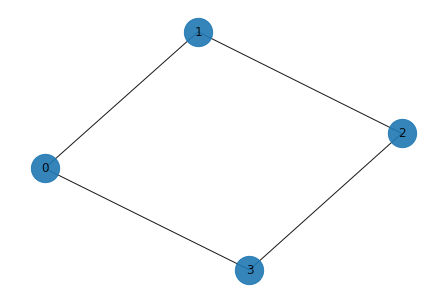

In [14]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.9, node_size=800)

In [36]:
G.edges()

EdgeView([(0, 1), (0, 3), (1, 2), (2, 3)])

In [40]:
for i, j in G.edges():
    print(i,j)

0 1
0 3
1 2
2 3


In [15]:
#for pair in list(G.edges()):  # pairs of nodes
#    print(pair[0],pair[1])

$\bf{step 3}$: The QAOA circuit

So far we have seen that the preparation of a quantum state during QAOA is composed of three elements

Preparing an initial state

Applying the unitary $U(H_{P})=e^{-iγH_P}$ corresponding to the problem Hamiltonian

Then, applying the mixing unitary $U(H_{B})=e^{−iβH_B}$

3A: The Initial State

The initial state used during QAOA is usually an equal superposition of all the basis states i.e.
|ψ0⟩=(1√2(|0⟩+|1⟩))⊗n

Such a state, when number of qubits is 4 (n=4
), can be prepared by applying Hadamard gates starting from an all zero state as shown in the circuit below.

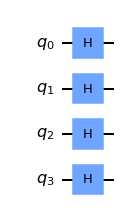

In [32]:
nqubits = 4
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw('mpl')

3B: The problem unitary:

\begin{equation}
U(H_{P})=e^{-iγH_C}
\end{equation}

\begin{equation}
H_{C}=\frac{1}{2}(Z_{0}\otimes Z_{1}\otimes I_2\otimes I_3)+\frac{1}{2}(I_{0}\otimes Z_{1}\otimes Z_2\otimes I_3)+...+\frac{1}{2}(I_{0}\otimes I_{1}\otimes Z_2\otimes Z_3)
\end{equation}

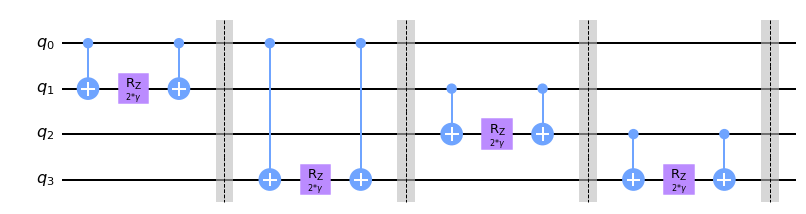

In [17]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw('mpl')

3C: The mixer unitary: 

\begin{equation}
U(H_{M})=e^{−iβH_M}
\end{equation}

\begin{equation}
H_{M}=\frac{1}{2}(X_{0}\otimes I_{1}\otimes I_2\otimes I_3)+\frac{1}{2}(I_{0}\otimes X_{1}\otimes I_2\otimes I_3)+...+\frac{1}{2}(I_{0}\otimes I_{1}\otimes I_2\otimes X_3) 
\end{equation}


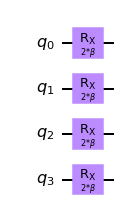

In [18]:
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw('mpl')

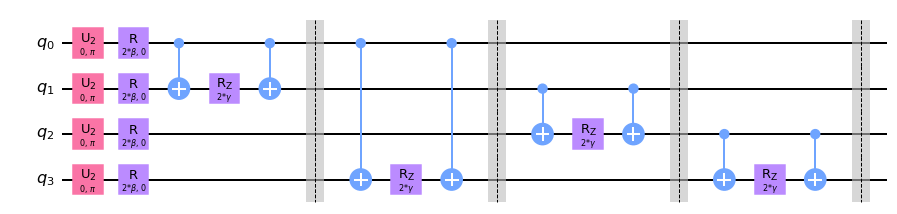

In [33]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])


qc_qaoa.decompose().decompose().draw('mpl')

$\bf{step  4}$: The next step is to find the optimal parameters $(β_{opt},γ_{opt})$

such that the expectation value
$⟨β_{opt},γ_{opt}|H_P|β_{opt},γ_{opt}⟩$ is minimized. Such an expectation can be obtained by doing measurement in the Z-basis.


1.Initialize β and γ to suitable real values.

2.Repeat until some suitable convergence criteria is met:

    -Prepare the state |ψ(β,γ)⟩ using qaoa circuit

    -Measure the state in standard basis

    -Compute ⟨ψ(β,γ)|H_P|ψ(β,γ)⟩

    -Find new set of parameters (βnew,γnew) using a classical optimization algorithm

    -Set current parameters (β,γ)equal to the new parameters (βnew,γnew)

In [20]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


In [ ]:
def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [21]:
# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc


In [22]:
# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ


In [28]:
expectation = get_expectation(G, p=1)
res = minimize(expectation, [1.0, 1.0], method='COBYLA')

In [31]:
res.x

array([1.9793337 , 1.16663483])

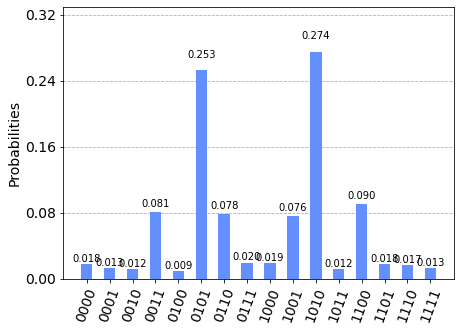

In [26]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

As we notice that the bitstrings "0101" and "1010" have the highest probability and are indeed the assignments of the graph (we started with) that gives 4 edges between the two partitions.